In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv("/content/Экономика_КНДР - Лист1.csv")


for col in df.columns:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].str.replace(",", ".")
    df[col] = df[col].str.replace("%", "")
    df[col] = pd.to_numeric(df[col], errors='coerce')


df["Промышленность (млн USD)"] = df["ВВП (млн USD)"] * df["Доля промышленности (%)"] / 100
df["Сельское хоз-во (млн USD)"] = df["ВВП (млн USD)"] * df["Доля с/х в ВВП (%)"] / 100


X_raw = df[["Население (млн)", "ВВП (млн USD)", "Промышленность (млн USD)",
            "Сельское хоз-во (млн USD)", "Потребление энергии (млрд кВт·ч)"]]
y_raw = df["Реконструированный GMI"]


X_diff = pd.DataFrame()
for col in X_raw.columns:
    result = adfuller(X_raw[col].dropna())
    pval = result[1]
    if col != "Потребление энергии (млрд кВт·ч)" and pval > 0.05:
        print(f"{col}: нестационарен (p = {pval:.3f}) → первая разность")
        X_diff[col] = X_raw[col].diff()
    else:
        print(f"{col}: стационарен или исключение (p = {pval:.3f}) → без разности")
        X_diff[col] = X_raw[col]


y = y_raw.diff()


data = pd.concat([y, X_diff], axis=1).dropna()
y_model = data.iloc[:, 0]
X_model_full = sm.add_constant(data.iloc[:, 1:])


def generate_models_by_removal(X, y):
    models = []
    X_current = X.copy()
    while True:
        model = sm.OLS(y, X_current).fit()
        models.append((model, X_current.columns.tolist()))
        pvals = model.pvalues.drop("const")
        if len(pvals) == 0 or pvals.max() < 0.05:
            break
        worst = pvals.idxmax()
        print(f"Удаляем переменную: {worst} (p = {pvals[worst]:.3f})")
        X_current = X_current.drop(columns=worst)
    return models


models = generate_models_by_removal(X_model_full, y_model)


for i, (model, variables) in enumerate(models):
    print(f"\n=== Модель {i+1} ===")
    print(f"Переменные: {variables}")
    print(model.summary())

Население (млн): нестационарен (p = 0.137) → первая разность
ВВП (млн USD): нестационарен (p = 1.000) → первая разность
Промышленность (млн USD): нестационарен (p = 0.999) → первая разность
Сельское хоз-во (млн USD): нестационарен (p = 0.999) → первая разность
Потребление энергии (млрд кВт·ч): стационарен или исключение (p = 0.000) → без разности
Удаляем переменную: Промышленность (млн USD) (p = 0.935)
Удаляем переменную: Потребление энергии (млрд кВт·ч) (p = 0.730)
Удаляем переменную: ВВП (млн USD) (p = 0.529)
Удаляем переменную: Сельское хоз-во (млн USD) (p = 0.707)

=== Модель 1 ===
Переменные: ['const', 'Население (млн)', 'ВВП (млн USD)', 'Промышленность (млн USD)', 'Сельское хоз-во (млн USD)', 'Потребление энергии (млрд кВт·ч)']
                              OLS Regression Results                              
Dep. Variable:     Реконструированный GMI   R-squared:                       0.482
Model:                                OLS   Adj. R-squared:                  0.359
Method:

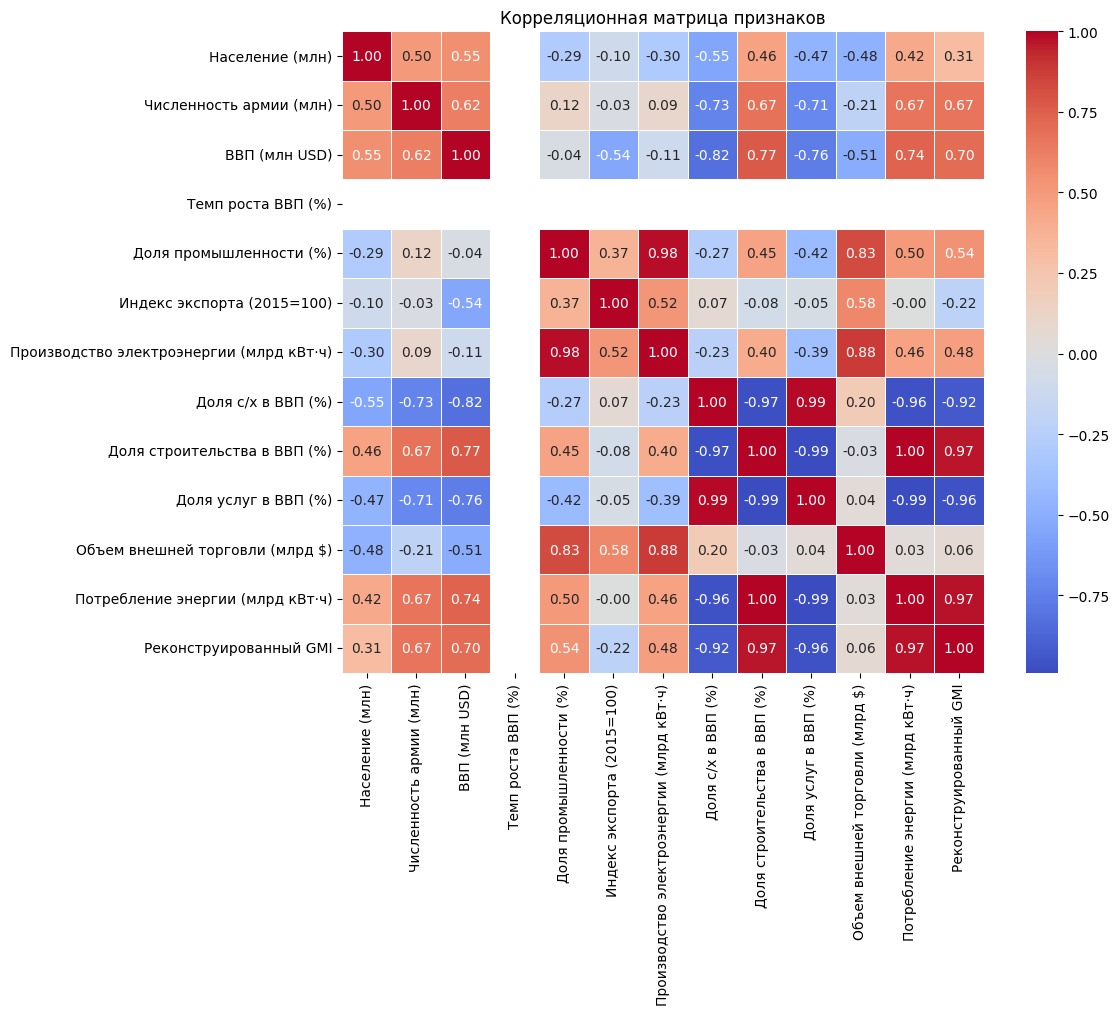

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/Экономика_КНДР - Лист1.csv')


for col in df.columns:
    if col != 'Год':
        df[col] = df[col].astype(str).str.replace(',', '.')
        df[col] = pd.to_numeric(df[col], errors='coerce')


df_corr = df.drop(columns=['Год'])


corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Корреляционная матрица признаков")
plt.tight_layout()
plt.show()

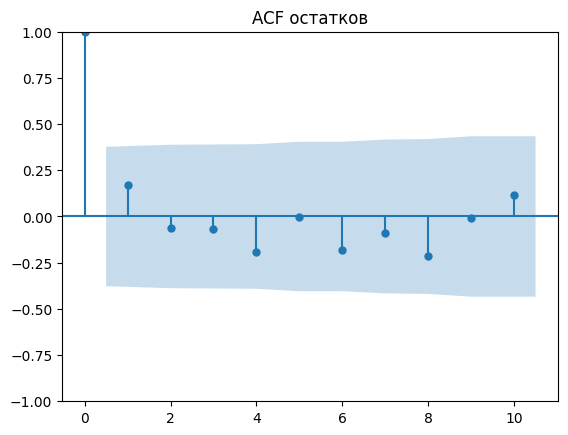

Ljung-Box тест (lag=10):
     lb_stat  lb_pvalue
10  6.511393   0.770626


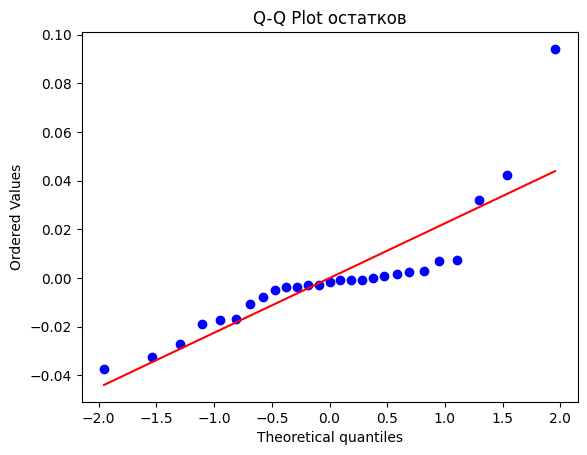


Shapiro-Wilk тест:
Статистика = 0.7741, p-value = 0.0001

Jarque-Bera тест:
Статистика = 58.8879, p-value = 0.0000


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = models[-1][0].resid


sm.graphics.tsa.plot_acf(residuals, lags=10)
plt.title("ACF остатков")
plt.show()

ljung_box = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box тест (lag=10):")
print(ljung_box)

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot остатков")
plt.show()

shapiro_test = stats.shapiro(residuals)
print("\nShapiro-Wilk тест:")
print(f"Статистика = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

jb_test = stats.jarque_bera(residuals)
print("\nJarque-Bera тест:")
print(f"Статистика = {jb_test.statistic:.4f}, p-value = {jb_test.pvalue:.4f}")

In [ ]:
final_vars_no_const = [var for var in final_vars if var != "const"]
X_scaled_const = sm.add_constant(data[final_vars_no_const])
y_clean = y_model

breakpoint = len(data) // 2
X1 = X_scaled_const[:breakpoint]
y1 = y_clean[:breakpoint]
X2 = X_scaled_const[breakpoint:]
y2 = y_clean[breakpoint:]

model_full = sm.OLS(y_clean, X_scaled_const).fit()
RSS_full = np.sum(model_full.resid ** 2)

model_1 = sm.OLS(y1, X1).fit()
model_2 = sm.OLS(y2, X2).fit()
RSS_1 = np.sum(model_1.resid ** 2)
RSS_2 = np.sum(model_2.resid ** 2)

k = X_scaled_const.shape[1]
n = len(y_clean)

numerator = (RSS_full - (RSS_1 + RSS_2)) / k
denominator = (RSS_1 + RSS_2) / (n - 2 * k)
F_chow = numerator / denominator
p_value = 1 - f.cdf(F_chow, k, n - 2 * k)

print("\n=== Chow Test ===")
print(f"F-статистика: {F_chow:.4f}")
print(f"p-значение: {p_value:.4f}")
if p_value < 0.05:
    print("→ Обнаружен структурный сдвиг.")
else:
    print("→ Нет статистически значимого структурного сдвига.")


=== Chow Test ===
F-статистика: 0.6928
p-значение: 0.5103
→ Нет статистически значимого структурного сдвига.


In [ ]:
# === Поиск оптимальной точки структурного сдвига ===
print("\n=== Автоматический поиск структурного сдвига ===")
best_breakpoint = None
max_f_stat = -np.inf
best_p_val = 1.0

start = int(len(data) * 0.1)
end = int(len(data) * 0.9)

for bp in range(start, end):
    X1 = X_scaled_const.iloc[:bp]
    y1 = y_clean.iloc[:bp]
    X2 = X_scaled_const.iloc[bp:]
    y2 = y_clean.iloc[bp:]

    if len(X1) < k or len(X2) < k:
        continue  # слишком мало наблюдений

    model_1 = sm.OLS(y1, X1).fit()
    model_2 = sm.OLS(y2, X2).fit()

    RSS_1 = np.sum(model_1.resid ** 2)
    RSS_2 = np.sum(model_2.resid ** 2)
    RSS_full = np.sum(sm.OLS(y_clean, X_scaled_const).fit().resid ** 2)

    numerator = (RSS_full - (RSS_1 + RSS_2)) / k
    denominator = (RSS_1 + RSS_2) / (len(y_clean) - 2 * k)
    F_chow = numerator / denominator
    p_val = 1 - f.cdf(F_chow, k, len(y_clean) - 2 * k)

    if F_chow > max_f_stat:
        max_f_stat = F_chow
        best_breakpoint = bp
        best_p_val = p_val

print(f"\nЛучшая точка сдвига: индекс {best_breakpoint} → год: {df['Год'].iloc[best_breakpoint]}")
print(f"F-статистика: {max_f_stat:.4f}")
print(f"p-значение: {best_p_val:.4f}")
if best_p_val < 0.05:
    print("→ Обнаружен статистически значимый структурный сдвиг.")
else:
    print("→ Нет статистически значимого структурного сдвига.")


=== Автоматический поиск структурного сдвига ===

Лучшая точка сдвига: индекс 6 → год: 2000
F-статистика: 3.4418
p-значение: 0.0492
→ Обнаружен статистически значимый структурный сдвиг.


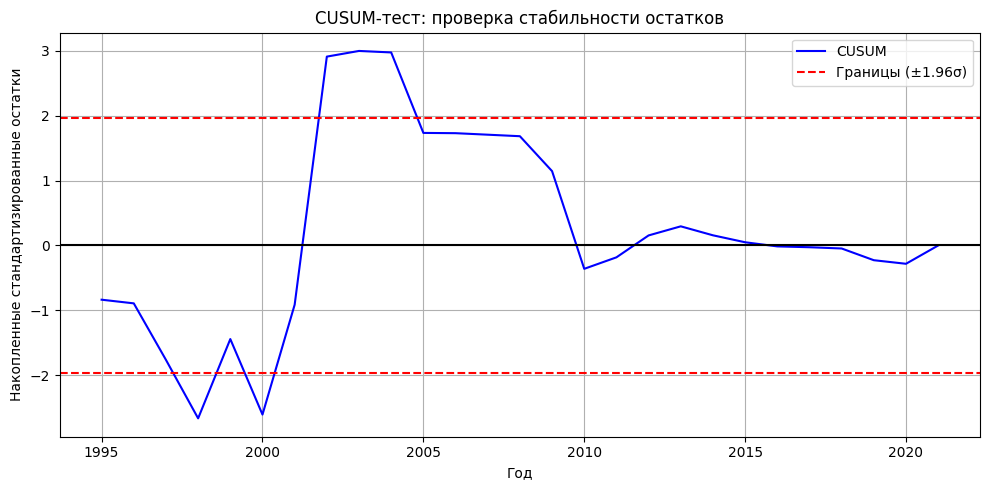

📌 Годы структурных сдвигов по CUSUM: [1998, 2000, 2002, 2003, 2004]


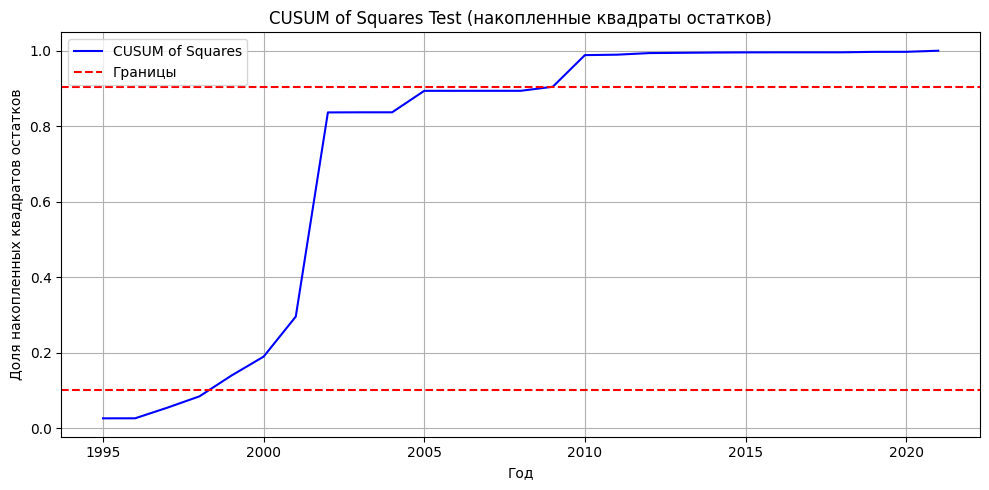

📌 Годы структурных сдвигов по CUSUM of Squares: [1995, 1996, 1997, 1998, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

residuals = model.resid
resid_sq = residuals ** 2

years = list(range(1994, 2022))


if len(years) > len(residuals):
    years = years[-len(residuals):]

#CUSUM
cusum = np.cumsum((residuals - np.mean(residuals)) / np.std(residuals))
upper_bound = 1.96
lower_bound = -1.96

plt.figure(figsize=(10, 5))
plt.plot(years, cusum, label="CUSUM", color="blue")
plt.axhline(upper_bound, color='red', linestyle='--', label="Границы (±1.96σ)")
plt.axhline(lower_bound, color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='-')
plt.title("CUSUM-тест: проверка стабильности остатков")
plt.xlabel("Год")
plt.ylabel("Накопленные стандартизированные остатки")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

exceed_indices = np.where((cusum > upper_bound) | (cusum < lower_bound))[0]
exceed_years = [years[i] for i in exceed_indices]
print("Годы структурных сдвигов по CUSUM:", exceed_years)

#CUSUMSQ
cusum_sq = np.cumsum(resid_sq) / np.sum(resid_sq)
n = len(resid_sq)
lower_bound_sq = 0.1
upper_bound_sq = 0.9 + 0.1 / n

plt.figure(figsize=(10, 5))
plt.plot(years, cusum_sq, label="CUSUM of Squares", color="blue")
plt.axhline(lower_bound_sq, color='red', linestyle='--', label="Границы")
plt.axhline(upper_bound_sq, color='red', linestyle='--')
plt.title("CUSUM of Squares Test (накопленные квадраты остатков)")
plt.xlabel("Год")
plt.ylabel("Доля накопленных квадратов остатков")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

exceed_sq_indices = np.where((cusum_sq < lower_bound_sq) | (cusum_sq > upper_bound_sq))[0]
exceed_sq_years = [years[i] for i in exceed_sq_indices]
print("Годы структурных сдвигов по CUSUM of Squares:", exceed_sq_years)

In [ ]:
from statsmodels.api import OLS, add_constant

# Добавим столбец с годами, если его ещё нет
df["Год"] = range(1994, 1994 + len(df))

# Используем уже готовые данные
X_qlr = X_model_full.reset_index(drop=True)
y_qlr = y_model.reset_index(drop=True)

min_size = int(0.15 * len(y_qlr))  # минимум наблюдений до и после точки разрыва
f_stats = []

for i in range(min_size, len(y_qlr) - min_size):
    model1 = OLS(y_qlr[:i], X_qlr[:i]).fit()
    model2 = OLS(y_qlr[i:], X_qlr[i:]).fit()
    rss1 = np.sum(model1.resid ** 2)
    rss2 = np.sum(model2.resid ** 2)
    rss_pooled = np.sum(OLS(y_qlr, X_qlr).fit().resid ** 2)

    k = X_qlr.shape[1]
    n = len(y_qlr)

    f = ((rss_pooled - (rss1 + rss2)) / k) / ((rss1 + rss2) / (n - 2 * k))
    f_stats.append(f)

max_F = max(f_stats)
break_index = f_stats.index(max_F) + min_size
break_year = df.iloc[break_index]["Год"]

print(f"Max F-statistic: {max_F:.4f}")
print(f"Предполагаемая точка перелома: индекс {break_index} (год: {break_year})")

Max F-statistic: 3.8331
Предполагаемая точка перелома: индекс 8 (год: 2002.0)


➡️ Обнаруженные точки возможных сдвигов в речевой милитаризации (TF-IDF):
– 1999
– 2004


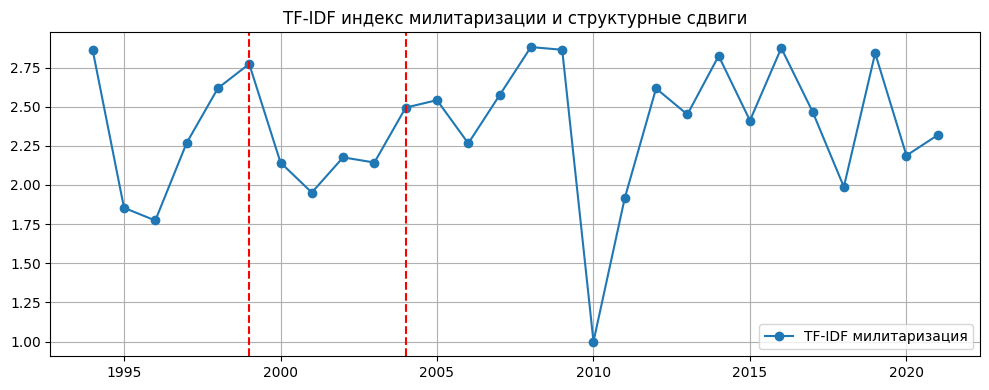


➡️ Обнаруженные точки возможных сдвигов в речевой милитаризации (LDA):
– 2014
– 2019


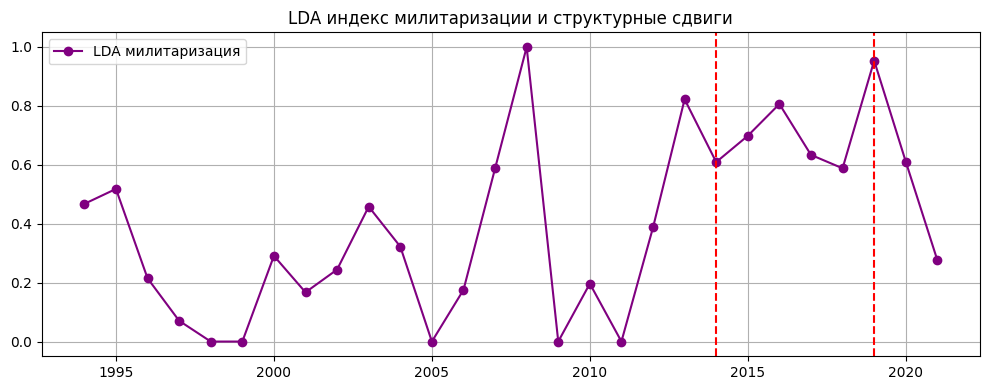

In [ ]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt


tfidf = pd.read_csv('/content/speeches_with_militarization-3.csv')  # Date, militarization_score
tfidf['Year'] = pd.to_datetime(tfidf['Date'], dayfirst=True).dt.year
tfidf_yearly = tfidf.groupby('Year')['militarization_score'].mean().reset_index()

if 2007 not in tfidf_yearly['Year'].values:
    score_2006 = tfidf_yearly.loc[tfidf_yearly['Year'] == 2006, 'militarization_score'].values[0]
    score_2008 = tfidf_yearly.loc[tfidf_yearly['Year'] == 2008, 'militarization_score'].values[0]
    score_2007 = (score_2006 + score_2008) / 2
    tfidf_yearly = pd.concat([
        tfidf_yearly,
        pd.DataFrame({'Year': [2007], 'militarization_score': [score_2007]})
    ]).sort_values('Year').reset_index(drop=True)

signal = tfidf_yearly['militarization_score'].values
algo = rpt.Pelt(model="rbf").fit(signal)
breaks = algo.predict(pen=0.5)

break_years = [int(tfidf_yearly['Year'].iloc[b]) for b in breaks if b < len(tfidf_yearly)]

print("Обнаруженные точки возможных сдвигов в речевой милитаризации (TF-IDF):")
if break_years:
    for year in break_years:
        print(f"– {year}")
else:
    print("Точек сдвига не обнаружено.")


plt.figure(figsize=(10, 4))
plt.plot(tfidf_yearly['Year'], tfidf_yearly['militarization_score'], marker='o', label='TF-IDF милитаризация')
for year in break_years:
    plt.axvline(x=year, color='red', linestyle='--')
plt.title('TF-IDF индекс милитаризации и структурные сдвиги')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

lda = pd.read_csv('/content/speeches_spicy_with_lda_score-2.csv')
lda['Year'] = pd.to_datetime(lda['Date'], dayfirst=True).dt.year
lda_yearly = lda.groupby('Year')['lda_militarization_score'].mean().reset_index()

if 2007 not in lda_yearly['Year'].values:
    score_2006 = lda_yearly.loc[lda_yearly['Year'] == 2006, 'lda_militarization_score'].values[0]
    score_2008 = lda_yearly.loc[lda_yearly['Year'] == 2008, 'lda_militarization_score'].values[0]
    score_2007 = (score_2006 + score_2008) / 2
    lda_yearly = pd.concat([
        lda_yearly,
        pd.DataFrame({'Year': [2007], 'lda_militarization_score': [score_2007]})
    ]).sort_values('Year').reset_index(drop=True)


signal_lda = lda_yearly['lda_militarization_score'].values
algo_lda = rpt.Pelt(model="rbf").fit(signal_lda)
breaks_lda = algo_lda.predict(pen=0.5)

break_years_lda = [int(lda_yearly['Year'].iloc[b]) for b in breaks_lda if b < len(lda_yearly)]

print("\Обнаруженные точки возможных сдвигов в речевой милитаризации (LDA):")
if break_years_lda:
    for year in break_years_lda:
        print(f"– {year}")
else:
    print("Точек сдвига не обнаружено.")


plt.figure(figsize=(10, 4))
plt.plot(lda_yearly['Year'], lda_yearly['lda_militarization_score'], marker='o', color='purple', label='LDA милитаризация')
for year in break_years_lda:
    plt.axvline(x=year, color='red', linestyle='--')
plt.title('LDA индекс милитаризации и структурные сдвиги')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

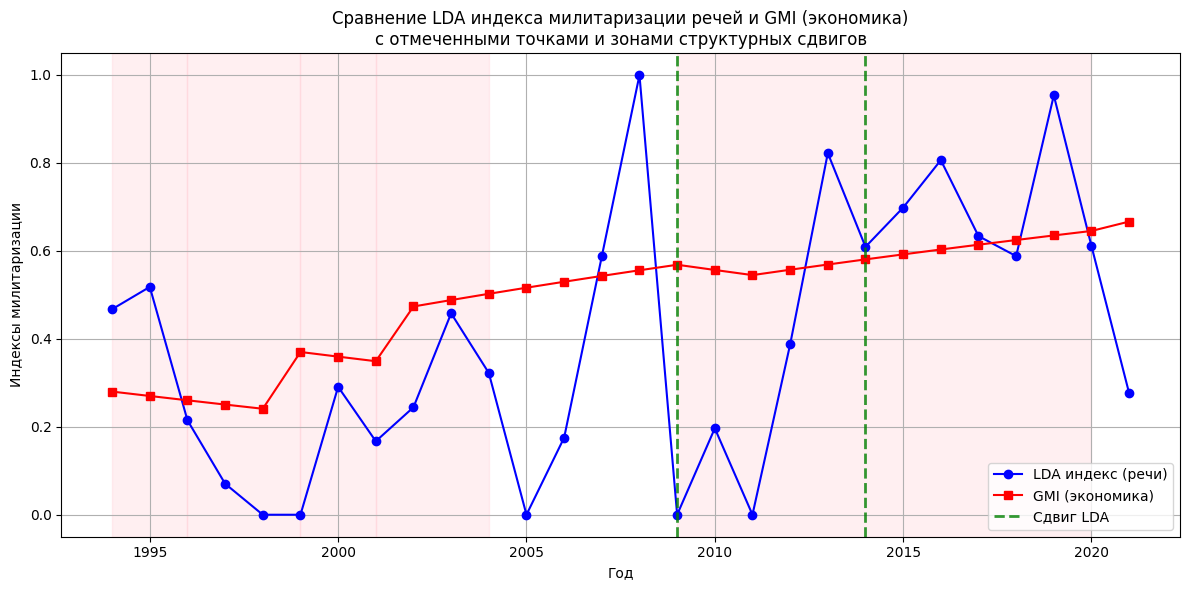

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


lda = pd.read_csv('/content/speeches_spicy_with_lda_score-2.csv')
gmi = pd.read_csv('/content/Экономика_КНДР - Лист1-3.csv')


lda['Year'] = pd.to_datetime(lda['Date'], dayfirst=True).dt.year
gmi['Year'] = gmi['Date'].astype(str).str.extract(r'(\d{4})').astype(int)


lda_yearly = lda.groupby('Year')['lda_militarization_score'].mean().reset_index()


if 2007 not in lda_yearly['Year'].values:
    try:
        score_2006 = lda_yearly.loc[lda_yearly['Year'] == 2006, 'lda_militarization_score'].values[0]
        score_2008 = lda_yearly.loc[lda_yearly['Year'] == 2008, 'lda_militarization_score'].values[0]
        score_2007 = (score_2006 + score_2008) / 2
        lda_yearly = pd.concat([
            lda_yearly,
            pd.DataFrame({'Year': [2007], 'lda_militarization_score': [score_2007]})
        ])
        lda_yearly = lda_yearly.sort_values('Year').reset_index(drop=True)
    except IndexError:
        print("Нет данных для 2006 или 2008 года")


gmi_clean = gmi[['Year', 'Реконструированный GMI']].dropna()
gmi_clean['Реконструированный GMI'] = gmi_clean['Реконструированный GMI'].astype(str).str.replace(',', '.').astype(float)

df = pd.merge(lda_yearly, gmi_clean, on='Year')

break_zones = [
    (1994, 1996),   # CUSUMSQ
    (1996, 1999),   # CUSUM
    (1999, 2001),   # Визуально
    (2001, 2004),   # CUSUM + QLR
    (2009, 2020)    # Длинная зона по CUSUMSQ
]


lda_breakpoints = [2009, 2014]


plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['lda_militarization_score'], label='LDA индекс (речи)', marker='o', color='blue')
plt.plot(df['Year'], df['Реконструированный GMI'], label='GMI (экономика)', marker='s', color='red')

for start, end in break_zones:
    plt.axvspan(start, end, color='pink', alpha=0.25)


for bp in lda_breakpoints:
    plt.axvline(bp, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Сдвиг LDA' if bp == lda_breakpoints[0] else "")

plt.title("Сравнение LDA индекса милитаризации речей и GMI (экономика)\nс отмеченными точками и зонами структурных сдвигов")
plt.xlabel("Год")
plt.ylabel("Индексы милитаризации")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

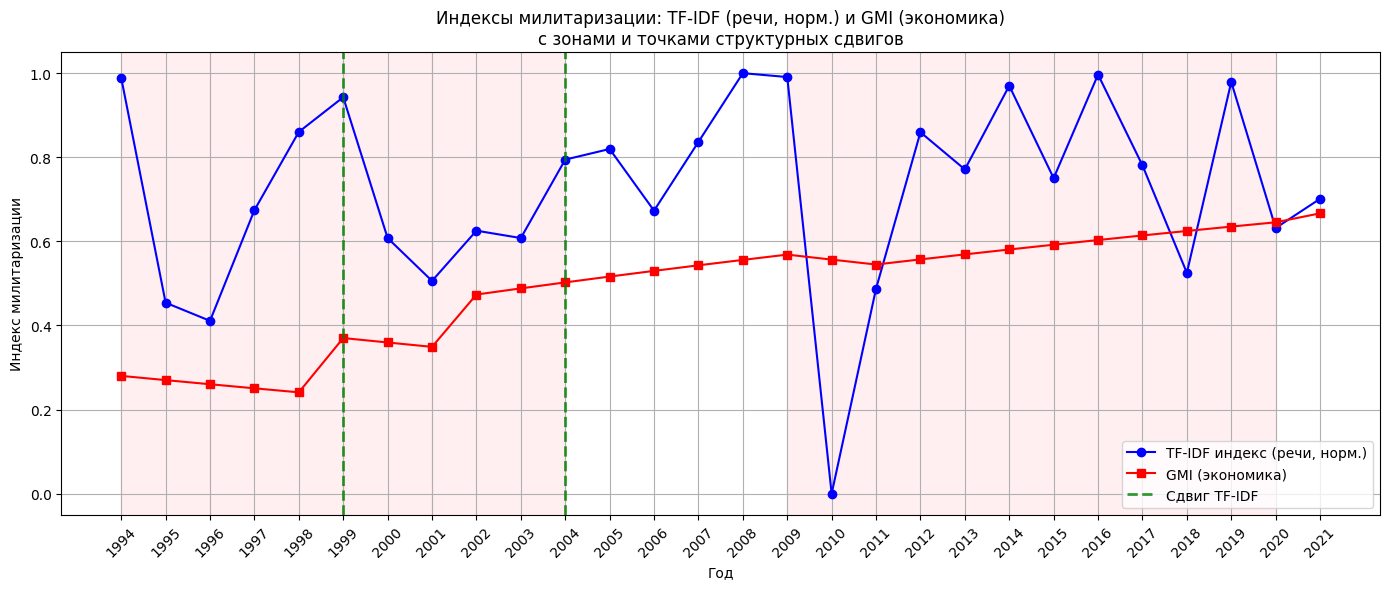

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


lda = pd.read_csv('/content/speeches_with_militarization-3.csv')
gmi = pd.read_csv('/content/Экономика_КНДР - Лист1-3.csv')

lda['Year'] = pd.to_datetime(lda['Date'], dayfirst=True).dt.year
lda_yearly = lda.groupby('Year')['militarization_score'].mean().reset_index()

if 2007 not in lda_yearly['Year'].values:
    try:
        score_2006 = lda_yearly.loc[lda_yearly['Year'] == 2006, 'militarization_score'].values[0]
        score_2008 = lda_yearly.loc[lda_yearly['Year'] == 2008, 'militarization_score'].values[0]
        score_2007 = (score_2006 + score_2008) / 2
        lda_yearly = pd.concat([
            lda_yearly,
            pd.DataFrame({'Year': [2007], 'militarization_score': [score_2007]})
        ])
        lda_yearly = lda_yearly.sort_values('Year').reset_index(drop=True)
    except IndexError:
        print("Нет данных для 2006 или 2008 года")

gmi['Year'] = gmi['Date'].astype(str).str.extract(r'(\d{4})').astype(int)
gmi_clean = gmi[['Year', 'Реконструированный GMI']].dropna()
gmi_clean['Реконструированный GMI'] = gmi_clean['Реконструированный GMI'].astype(str).str.replace(',', '.').astype(float)

df = pd.merge(lda_yearly, gmi_clean, on='Year')


scaler = MinMaxScaler()
df['militarization_score_norm'] = scaler.fit_transform(df[['militarization_score']])

break_zones = [
    (1994, 1996),
    (1996, 1999),
    (1999, 2001),
    (2001, 2004),
    (2009, 2020)
]
tfidf_breakpoints = [1999, 2004]


plt.figure(figsize=(14, 6))
plt.plot(df['Year'], df['militarization_score_norm'], label='TF-IDF индекс (речи, норм.)', marker='o', color='blue')
plt.plot(df['Year'], df['Реконструированный GMI'], label='GMI (экономика)', marker='s', color='red')


for start, end in break_zones:
    plt.axvspan(start, end, color='pink', alpha=0.25)


for bp in tfidf_breakpoints:
    plt.axvline(bp, color='green', linestyle='--', linewidth=2, alpha=0.8,
                label='Сдвиг TF-IDF' if bp == tfidf_breakpoints[0] else "")


plt.xticks(df['Year'].unique(), rotation=45)

plt.title("Индексы милитаризации: TF-IDF (речи, норм.) и GMI (экономика)\nс зонами и точками структурных сдвигов")
plt.xlabel("Год")
plt.ylabel("Индекс милитаризации")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()